In [1]:
import sys
sys.path.append('..')

from preference_datasets import get_batch_iterator
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel, PeftConfig
import datasets
import matplotlib.pyplot as plt
import random

In [2]:
lora_dir='/scratch/ssumathi/Re-tuning/ReTuning-main/cache/ssumathi/my_recursive_add_7b_2024-11-14_02-51-28_056513/LATEST'

model = AutoModelForCausalLM.from_pretrained('huggyllama/llama-7b',torch_dtype=torch.float16,device_map='auto')
model = PeftModel.from_pretrained(model, lora_dir,offload_buffer=True)

tokenizer = AutoTokenizer.from_pretrained("huggyllama/llama-7b")
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

/scratch/ssumathi/Re-tuning/retuning_env/lib/python3.8/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
def generate_from_prompt(model,prompt,tokenizer,max_length,temperature):
    input_tok=tokenizer(prompt,add_special_tokens=False)
    input_ids=torch.LongTensor(input_tok['input_ids']).cuda()
    attention_mask=torch.LongTensor(input_tok['attention_mask']).cuda()
    tokenized_samples = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=max_length, 
        do_sample=True, 
        temperature=temperature, 
        pad_token_id=tokenizer.pad_token_id
    )
    return tokenizer.batch_decode(tokenized_samples,skip_special_tokens=True)

def recursive_generate(model,input_string,tokenizer,max_length,temperature,max_rec=30,current_rec=0):
    sample=generate_from_prompt(model,input_string,tokenizer,max_length,temperature)
    
    if current_rec>=max_rec:
        print('exceeded max recursion')
        return sample
    if 'Call: ' in sample[0]:
        call=sample[0].split('Call: ')[-1]
        if '\n' in call:
            call=call.split('\n')[0]+'\nSolution: '
            call_ret=recursive_generate(model,[call],tokenizer,max_length,temperature,max_rec,current_rec+1)
        else:
            print('bad call')
            return sample
        call_out=call_ret[0].split('  ')[-1]
        new_prompt=(sample[0]+'Return: '+call_out+'\nAnswer: ').replace('  ',' ')
        sample=generate_from_prompt(model,[new_prompt],tokenizer,max_length,temperature)
    return sample

In [4]:
samples_with_solutions={}
eval_lengths=range(2,62)
for num_digits in eval_lengths:
    print(f"Evaluating length:{num_digits}")
    samples_with_solutions[num_digits]=[]
    for _ in range(3):
        a=random.randint(10**(num_digits-1),10**num_digits-1)
        b=random.randint(10**(num_digits-1),10**num_digits-1)
        sample=recursive_generate(model,[f'{a} + {b}\nSolution: '],tokenizer,max_length=2048,temperature=.01,max_rec=num_digits*2)
        samples_with_solutions[num_digits].append((sample,str(a+b),a,b))

Evaluating length:25
Evaluating length:26
Evaluating length:27
Evaluating length:28
Evaluating length:29


25 1.0
26 1.0
27 1.0
28 0.6666666666666666
29 0.3333333333333333


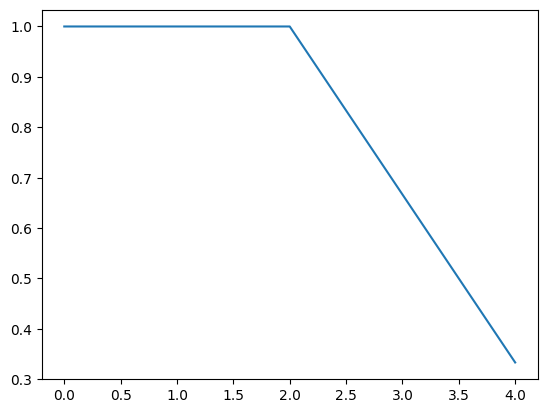

In [5]:
accs=[]
for num_digits in eval_lengths:
    num_right=0
    total=0
    correct_arr=[]
    incorrect_arr=[]
    for sample in samples_with_solutions[num_digits]:
        total+=1
        sample_arr=sample[0][0].split(' ')
        carr=sample_arr[-3][:-1]
        output=sample_arr[-1]
        if carr=='1': num_str=carr+output
        else: num_str=output
        if num_str==sample[1]:
            num_right+=1
            correct_arr.append(sample)
        else:incorrect_arr.append(sample)
    print(num_digits, num_right/total)
    accs.append(num_right/total)
plt.plot(accs)
plt.show()